In [1]:
import numpy as np
import math
import pandas as pd
from pandas import DataFrame,Series
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.utils.multiclass import type_of_target
import lightgbm as lgb

In [2]:
#读入数据
data = pd.read_csv(r'C:\Users\Apple\Desktop\data.csv',encoding='gbk')
#print(data.info())
data.head()

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,...,loans_max_limit,loans_avg_limit,consfin_credit_limit,consfin_credibility,consfin_org_count_current,consfin_product_count,consfin_max_limit,consfin_avg_limit,latest_query_day,loans_latest_day
0,5,2791858,20180507115231274000000023057383,卡号1,0.01,0.99,0,0.90,0.55,0.313,...,2900.0,1688.0,1200.0,75.0,1.0,2.0,1200.0,1200.0,12.0,18.0
1,10,534047,20180507121002192000000023073000,卡号1,0.02,0.94,2000,1.28,1.00,0.458,...,3500.0,1758.0,15100.0,80.0,5.0,6.0,22800.0,9360.0,4.0,2.0
2,12,2849787,20180507125159718000000023114911,卡号1,0.04,0.96,0,1.00,1.00,0.114,...,1600.0,1250.0,4200.0,87.0,1.0,1.0,4200.0,4200.0,2.0,6.0
3,13,1809708,20180507121358683000000388283484,卡号1,0.00,0.96,2000,0.13,0.57,0.777,...,3200.0,1541.0,16300.0,80.0,5.0,5.0,30000.0,12180.0,2.0,4.0
4,14,2499829,20180507115448545000000388205844,卡号1,0.01,0.99,0,0.46,1.00,0.175,...,2300.0,1630.0,8300.0,79.0,2.0,2.0,8400.0,8250.0,22.0,120.0


0    3561
1    1193
Name: status, dtype: int64


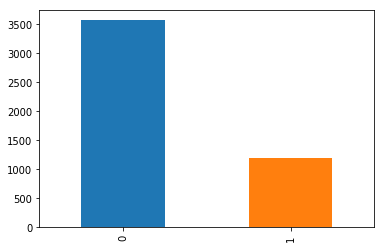

In [3]:
#查看结果的分布，好人和坏人的比例约为3:1
print(data['status'].value_counts())
data['status'].value_counts().plot(kind='bar')

In [4]:
#丢掉方差为0即没有变化的列
#df.drop(df.columns[df.std()==0],axis=1,inplace=True)
#df.shape

In [5]:
# #热力图研究相关性
# plt.figure(figsize=(54,46))
# corr=df.drop(['status'],axis=1).corr()
# #注意给lables值设置大小和格式,不然显示不清
# #show 列表名
# print(list(df))
# print(df.shape)
# sns.heatmap(corr,fmt='.2f',annot=True,cbar=False,annot_kws={'size':24,'weight':'bold'})

In [6]:
#计算缺失率和唯一率：删除一些不必要的列
data_1=pd.DataFrame(data.isnull().sum(),columns=['loss_num'])
data_2=pd.DataFrame(data.nunique(),columns=['unique_num'])
data_loss_unique=pd.merge(data_1,data_2,right_index=True,left_index=True)
data_loss_unique['loss_rate']=round(data_loss_unique['loss_num']/data.shape[0],5)
data_loss_unique['unique_rate']=round(data_loss_unique['unique_num']/data.shape[0],5)

data_loss_unique.head().T

,Unnamed: 0,custid,trade_no,bank_card_no,low_volume_percent
loss_num,0.0,0.0,0.0,0.00000,2.00000
unique_num,4754.0,4754.0,4754.0,1.00000,40.00000
loss_rate,0.0,0.0,0.0,0.00000,0.00042
unique_rate,1.0,1.0,1.0,0.00021,0.00841


In [7]:
#查看缺失比较验证的列
data_loss_unique.sort_values(by='loss_rate',ascending=False)

,loss_num,unique_num,loss_rate,unique_rate
student_feature,2998,2,0.63063,0.00042
cross_consume_count_last_1_month,426,19,0.08961,0.00400
latest_six_month_apply,304,65,0.06395,0.01367
latest_one_month_apply,304,36,0.06395,0.00757
latest_query_time,304,207,0.06395,0.04354
query_sum_count,304,74,0.06395,0.01557
query_cash_count,304,17,0.06395,0.00358
query_finance_count,304,25,0.06395,0.00526
query_org_count,304,46,0.06395,0.00968
apply_credibility,304,41,0.06395,0.00862


In [8]:
#查看唯一值情况 唯一率特别高或者特别低的都可以考虑删除
data_loss_unique.sort_values(by='unique_rate',ascending=False)

,loss_num,unique_num,loss_rate,unique_rate
Unnamed: 0,0,4754,0.00000,1.00000
trade_no,0,4754,0.00000,1.00000
custid,0,4754,0.00000,1.00000
historical_trans_amount,0,4524,0.00000,0.95162
id_name,276,4309,0.05806,0.90639
trans_amount_3_month,0,3524,0.00000,0.74127
pawns_auctions_trusts_consume_last_6_month,0,2730,0.00000,0.57425
repayment_capability,0,2390,0.00000,0.50273
consume_mini_time_last_1_month,26,1971,0.00547,0.41460
abs,0,1697,0.00000,0.35696


In [9]:
data.columns

Index(['Unnamed: 0', 'custid', 'trade_no', 'bank_card_no',
       'low_volume_percent', 'middle_volume_percent',
       'take_amount_in_later_12_month_highest',
       'trans_amount_increase_rate_lately', 'trans_activity_month',
       'trans_activity_day', 'transd_mcc', 'trans_days_interval_filter',
       'trans_days_interval', 'regional_mobility', 'student_feature',
       'repayment_capability', 'is_high_user', 'number_of_trans_from_2011',
       'first_transaction_time', 'historical_trans_amount',
       'historical_trans_day', 'rank_trad_1_month', 'trans_amount_3_month',
       'avg_consume_less_12_valid_month', 'abs',
       'top_trans_count_last_1_month', 'avg_price_last_12_month',
       'avg_price_top_last_12_valid_month', 'reg_preference_for_trad',
       'trans_top_time_last_1_month', 'trans_top_time_last_6_month',
       'consume_top_time_last_1_month', 'consume_top_time_last_6_month',
       'cross_consume_count_last_1_month',
       'trans_fail_top_count_enum_last_1_mont

In [10]:
data.shape

(4754, 90)

In [11]:
#综合上面两张表，可以得出：student_feature缺失严重，删掉；num、custid、id_name唯一率较高，无意义，可删掉；
#bank_card_no、trade_no、source唯一率极低，且无意义，删掉
columns_drop=['student_feature','bank_card_no','source','trade_no','id_name','Unnamed: 0','custid']
data.drop(columns=columns_drop,axis=1,inplace=True)

In [12]:
data.shape

(4754, 83)

In [13]:
#obj对象需要进一步处理reg_preference_for_trad 、latest_query_time、loans_latest_time
data.select_dtypes('object').columns

Index(['reg_preference_for_trad', 'latest_query_time', 'loans_latest_time'], dtype='object')

In [14]:
data['reg_preference_for_trad'].unique()

array(['一线城市', '三线城市', '境外', '二线城市', '其他城市', nan], dtype=object)

In [15]:
%%time
#处理latest_query_time、loans_latest_time，这两个日期与当前时间的差值是有意义的
data['latest_query_time'] = pd.to_datetime(data['latest_query_time'], format ='%Y-%m-%d')
data['loans_latest_time'] = pd.to_datetime(data['loans_latest_time'], format ='%Y-%m-%d')
today=pd.to_datetime('2019-5-13', format ='%Y-%m-%d')

data['loan_last_days']=abs(data['loans_latest_time']-today)
data['query_last_days']=abs(data['latest_query_time']-today)

for i,j in enumerate(data['loan_last_days']):
    data['loan_last_days'][i]=j.days

for i,j in enumerate(data['query_last_days']):
    data['query_last_days'][i]=j.days

data['loan_last_days']=data['loan_last_days'].astype('float')
data['query_last_days']=data['query_last_days'].astype('float')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


Wall time: 6min 6s


In [16]:
#处理完差值之后，删掉'latest_query_time','loans_latest_time'这两个无用变量
data.drop(['latest_query_time','loans_latest_time'],axis=1,inplace=True)

#之后查看数据情况
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 83 columns):
low_volume_percent                            4752 non-null float64
middle_volume_percent                         4752 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4751 non-null float64
trans_activity_month                          4752 non-null float64
trans_activity_day                            4752 non-null float64
transd_mcc                                    4752 non-null float64
trans_days_interval_filter                    4746 non-null float64
trans_days_interval                           4752 non-null float64
regional_mobility                             4752 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4752 non-null float64
first_transacti

In [17]:
data.shape

(4754, 83)

In [18]:
#接下来步骤，填充缺失值

In [19]:
data.select_dtypes('object').columns

Index(['reg_preference_for_trad'], dtype='object')

代码一/方法一

In [20]:
#处理缺失值，方法一
null=pd.DataFrame(data.isnull().sum(),columns=['num'])
null.astype('float')


null_lst=[]
for i,j in enumerate(null['num']):
    if j>0:
        null_lst.append(null.index[i])

#用众数填充，没有区分数值型和obj型，如果想用median中位数填充，需要区分数值型，参考代码二
for i in null_lst:
    fill_value=data[i].value_counts().index[0]
    data[i].fillna(fill_value, inplace=True)

代码二/方法二

In [21]:
##生成一个字典、代码二/方法二
#dict1=data.isnull().sum()
##
##去除缺失值为0的键值对，同时去除去除缺失值大于2000的键值对，这些稍后处理
#for i in list(dict1.keys()):
#    if dict1[i]==0:
#        del dict1[i]
##
#for j in list(dict1.keys()):
#    if dict1[j]>2000:
#        del dict1[j]
#len(dict1)
##
## 数值型数据中位数填充
#for key in dict1.keys():
#    if data[key].dtype != object:
#        data[key].fillna(data[key].median(),inplace = True)
#    else:
#        print('object类型的缺失值和个数',key,dict1[key])

In [22]:
pd.value_counts(data.status)

0    3561
1    1193
Name: status, dtype: int64

In [23]:
data[['reg_preference_for_trad','status']].groupby(data['reg_preference_for_trad'])['status'].count().reset_index()

,reg_preference_for_trad,status
0,一线城市,3405
1,三线城市,1064
2,二线城市,131
3,其他城市,4
4,境外,150


In [24]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 83 columns):
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4754 non-null float64
first_transacti

In [25]:
data.shape

(4754, 83)

In [26]:
data.select_dtypes('object').columns

Index(['reg_preference_for_trad'], dtype='object')

In [27]:
data_1=data.join(pd.get_dummies(data['reg_preference_for_trad']))
data_1

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_avg_limit,latest_query_day,loans_latest_day,loan_last_days,query_last_days,一线城市,三线城市,二线城市,其他城市,境外
0,0.01,0.99,0,0.90,0.55,0.313,17.0,27.0,26.0,3.0,...,1200.0,12.0,18.0,389.0,383.0,1,0,0,0,0
1,0.02,0.94,2000,1.28,1.00,0.458,19.0,30.0,14.0,4.0,...,9360.0,4.0,2.0,373.0,375.0,1,0,0,0,0
2,0.04,0.96,0,1.00,1.00,0.114,13.0,68.0,22.0,1.0,...,4200.0,2.0,6.0,377.0,373.0,1,0,0,0,0
3,0.00,0.96,2000,0.13,0.57,0.777,22.0,14.0,6.0,3.0,...,12180.0,2.0,4.0,375.0,373.0,0,1,0,0,0
4,0.01,0.99,0,0.46,1.00,0.175,13.0,66.0,42.0,1.0,...,8250.0,22.0,120.0,491.0,393.0,1,0,0,0,0
5,0.02,0.98,2000,7.59,1.00,0.733,27.0,8.0,11.0,3.0,...,8130.0,3.0,4.0,375.0,374.0,0,1,0,0,0
6,0.02,0.98,0,23.67,0.94,0.087,10.0,54.0,53.0,2.0,...,8900.0,1.0,3.0,374.0,372.0,1,0,0,0,0
7,0.02,0.98,0,0.25,0.88,0.302,19.0,20.0,20.0,2.0,...,0.0,23.0,4.0,375.0,394.0,1,0,0,0,0
8,0.03,0.65,0,0.31,0.76,0.472,15.0,21.0,14.0,2.0,...,7987.0,24.0,7.0,378.0,395.0,0,1,0,0,0
9,0.01,0.99,500,0.80,1.00,0.088,15.0,36.0,35.0,2.0,...,0.0,18.0,142.0,516.0,392.0,1,0,0,0,0


In [28]:
data_1.drop(columns=['reg_preference_for_trad'],axis=1,inplace=True)

In [29]:
data_1.shape

(4754, 87)

In [30]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 87 columns):
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4754 non-null float64
first_transacti

In [31]:
data_1[['一线城市', '三线城市', '境外', '二线城市', '其他城市']]=data_1[['一线城市', '三线城市', '境外', '二线城市', '其他城市']].astype('float')

In [32]:
data_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4754 entries, 0 to 4753
Data columns (total 87 columns):
low_volume_percent                            4754 non-null float64
middle_volume_percent                         4754 non-null float64
take_amount_in_later_12_month_highest         4754 non-null int64
trans_amount_increase_rate_lately             4754 non-null float64
trans_activity_month                          4754 non-null float64
trans_activity_day                            4754 non-null float64
transd_mcc                                    4754 non-null float64
trans_days_interval_filter                    4754 non-null float64
trans_days_interval                           4754 non-null float64
regional_mobility                             4754 non-null float64
repayment_capability                          4754 non-null int64
is_high_user                                  4754 non-null int64
number_of_trans_from_2011                     4754 non-null float64
first_transacti

# 区分X和Y

In [33]:
data_y=pd.DataFrame(data_1['status'])

In [34]:
data_y.shape

(4754, 1)

In [35]:
data_x=data_1.drop('status',axis=1,inplace=False)

In [36]:
data_x.shape

(4754, 86)

# 归一化MinMaxScaler和StandardScaler

In [37]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

min_max_scaler=MinMaxScaler()
std_scaler=StandardScaler()

In [38]:
data_x_std=pd.DataFrame(std_scaler.fit_transform(data_x),columns=data_x.columns)
data_x_min_max=pd.DataFrame(min_max_scaler.fit_transform(data_x),columns=data_x.columns)

In [39]:
#均值方差归一化
data_x_std

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_avg_limit,latest_query_day,loans_latest_day,loan_last_days,query_last_days,一线城市,三线城市,二线城市,其他城市,境外
0,-0.284251,0.612259,-0.494499,-0.019099,-1.292504,-0.307656,-0.112457,-0.088274,0.258136,0.360860,...,-1.081880,-0.329940,-0.638272,-0.649898,-0.347656,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
1,-0.043372,0.267007,0.015242,-0.018551,0.992929,0.544402,0.334549,0.043831,-0.470448,1.484325,...,0.317762,-0.549139,-0.938777,-0.950288,-0.567080,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
2,0.438384,0.405108,-0.494499,-0.018955,0.992929,-1.477031,-1.006468,1.717157,0.015275,-1.886068,...,-0.567306,-0.603939,-0.863651,-0.875190,-0.621936,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
3,-0.525129,0.405108,0.015242,-0.020208,-1.190929,2.418929,1.005058,-0.660727,-0.956171,0.360860,...,0.801462,-0.603939,-0.901214,-0.912739,-0.621936,-1.588739,1.862269,-0.168335,-0.029019,-0.180500
4,-0.284251,0.612259,-0.494499,-0.019733,0.992929,-1.118579,-1.006468,1.629087,1.229582,-1.886068,...,0.127370,-0.055941,1.277445,1.265084,-0.073376,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
5,-0.043372,0.543209,0.015242,-0.009457,0.992929,2.160373,2.122572,-0.924936,-0.652594,0.360860,...,0.106787,-0.576539,-0.901214,-0.912739,-0.594508,-1.588739,1.862269,-0.168335,-0.029019,-0.180500
6,-0.043372,0.543209,-0.494499,0.013716,0.688205,-1.635690,-1.676977,1.100668,1.897451,-0.762604,...,0.238861,-0.631339,-0.919995,-0.931513,-0.649364,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
7,-0.043372,0.543209,-0.494499,-0.020035,0.383480,-0.372295,0.334549,-0.396518,-0.106156,-0.762604,...,-1.287710,-0.028541,-0.901214,-0.912739,-0.045948,0.629430,-0.536979,-0.168335,-0.029019,-0.180500
8,0.197506,-1.735454,-0.494499,-0.019949,-0.225969,0.626670,-0.559462,-0.352483,-0.470448,-0.762604,...,0.082259,-0.001141,-0.844869,-0.856416,-0.018520,-1.588739,1.862269,-0.168335,-0.029019,-0.180500
9,-0.284251,0.612259,-0.367064,-0.019243,0.992929,-1.629814,-0.559462,0.308040,0.804574,-0.762604,...,-1.287710,-0.165540,1.690639,1.734442,-0.100804,0.629430,-0.536979,-0.168335,-0.029019,-0.180500


In [40]:
#0-1归一化：（x-min）/（max-min）
data_x_min_max

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_avg_limit,latest_query_day,loans_latest_day,loan_last_days,query_last_days,一线城市,三线城市,二线城市,其他城市,境外
0,0.01,0.99,0.000000,0.000019,0.488636,0.308370,0.375,0.094737,0.095652,0.50,...,0.014493,0.038674,0.061538,0.052308,0.033333,1.0,0.0,0.0,0.0,0.0
1,0.02,0.94,0.029412,0.000027,1.000000,0.468062,0.425,0.105263,0.043478,0.75,...,0.113043,0.016575,0.012308,0.003077,0.011111,1.0,0.0,0.0,0.0,0.0
2,0.04,0.96,0.000000,0.000021,1.000000,0.089207,0.275,0.238596,0.078261,0.00,...,0.050725,0.011050,0.024615,0.015385,0.005556,1.0,0.0,0.0,0.0,0.0
3,0.00,0.96,0.029412,0.000003,0.511364,0.819383,0.500,0.049123,0.008696,0.50,...,0.147101,0.011050,0.018462,0.009231,0.005556,0.0,1.0,0.0,0.0,0.0
4,0.01,0.99,0.000000,0.000010,1.000000,0.156388,0.275,0.231579,0.165217,0.00,...,0.099638,0.066298,0.375385,0.366154,0.061111,1.0,0.0,0.0,0.0,0.0
5,0.02,0.98,0.029412,0.000159,1.000000,0.770925,0.625,0.028070,0.030435,0.50,...,0.098188,0.013812,0.018462,0.009231,0.008333,0.0,1.0,0.0,0.0,0.0
6,0.02,0.98,0.000000,0.000497,0.931818,0.059471,0.200,0.189474,0.213043,0.25,...,0.107488,0.008287,0.015385,0.006154,0.002778,1.0,0.0,0.0,0.0,0.0
7,0.02,0.98,0.000000,0.000005,0.863636,0.296256,0.425,0.070175,0.069565,0.25,...,0.000000,0.069061,0.018462,0.009231,0.063889,1.0,0.0,0.0,0.0,0.0
8,0.03,0.65,0.000000,0.000007,0.727273,0.483480,0.325,0.073684,0.043478,0.25,...,0.096461,0.071823,0.027692,0.018462,0.066667,0.0,1.0,0.0,0.0,0.0
9,0.01,0.99,0.007353,0.000017,1.000000,0.060573,0.325,0.126316,0.134783,0.25,...,0.000000,0.055249,0.443077,0.443077,0.058333,1.0,0.0,0.0,0.0,0.0


In [44]:
data_x_min_max.shape

(4754, 86)

# 可以利用data_x_min_max做一次pca降维，不影响后续建模，后续建模用的均是data_x_std，但是没啥实际意义，试一下

In [41]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9)

In [42]:
data_x_min_max_pca = pca.fit_transform(data_x_min_max)

In [43]:
data_x_min_max_pca.shape

(4754, 21)

In [46]:
pd.DataFrame(data_x_min_max_pca)

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,0.181065,-0.346550,-0.237035,0.428557,-0.013716,0.003967,-0.086732,-0.142855,0.187561,0.020810,...,-0.208248,-0.012340,-0.045056,-0.062138,0.008489,-0.051385,-0.118920,0.016929,0.021331,0.075043
1,0.426241,-0.214308,-0.401187,-0.214172,0.387970,0.081094,-0.139850,0.161212,-0.391107,-0.203269,...,-0.218582,-0.060990,-0.061479,-0.056617,0.088943,-0.093759,-0.021756,-0.097128,-0.139618,-0.023721
2,-0.801715,-0.762831,0.269673,-0.428068,0.571488,-0.197131,0.058438,-0.371343,0.012515,0.176296,...,-0.083818,-0.028796,0.079440,-0.002546,-0.009029,-0.044010,-0.244447,0.161266,-0.063141,0.064932
3,0.436546,1.350390,-0.060195,0.455635,0.098920,0.165510,-0.300502,0.039677,0.095416,0.070899,...,-0.175476,0.006937,0.147568,-0.044022,0.098870,-0.009585,0.009112,-0.036451,-0.145327,-0.039038
4,-0.457656,-0.600625,0.779995,-0.387290,-0.179307,-0.062294,-0.160627,0.038459,0.211922,0.070578,...,0.074383,0.074765,-0.023560,-0.056594,0.168868,0.063183,-0.362814,0.025513,-0.080651,-0.280158
5,0.237911,1.275579,-0.114547,-0.235834,0.690356,0.451753,-0.376855,-0.035083,-0.277889,0.064877,...,0.016131,-0.090929,0.022214,-0.008204,-0.222812,-0.017414,0.095636,-0.163248,-0.015263,-0.065919
6,-0.849086,-0.807393,0.457265,-0.099256,0.455372,-0.122878,0.074015,-0.310105,-0.167409,-0.086541,...,0.045775,0.001727,-0.041637,0.037889,-0.041037,-0.011011,-0.157701,0.021922,-0.031995,-0.021981
7,0.025510,-0.398481,-0.350281,-0.127514,-0.300629,0.025823,0.129549,-0.303565,-0.026362,0.076366,...,-0.125973,-0.048449,0.245461,0.026754,-0.296732,0.287983,-0.165843,-0.078967,0.127301,-0.039568
8,-0.171186,1.101958,-0.204269,0.001586,-0.507864,0.135248,0.274504,-0.275534,-0.281960,0.046426,...,0.585644,0.040508,-0.244802,0.111065,-0.175146,-0.132745,0.017509,0.302982,0.042671,0.289266
9,-0.882125,-0.821947,0.371760,-0.267599,0.184294,-0.004094,-0.342519,0.128158,0.382059,-0.258326,...,-0.044551,-0.003662,-0.280732,0.590449,-0.129423,0.021636,-0.056829,-0.203408,-0.029266,-0.064340


In [47]:
pca_1 = PCA(n_components=30)

In [48]:
data_x_min_max_pca_1 = pca_1.fit_transform(data_x_min_max)

In [49]:
data_x_min_max_pca_1.shape

(4754, 30)

In [51]:
pd.DataFrame(data_x_min_max_pca_1)

,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.181065,-0.346550,-0.237035,0.428557,-0.013716,0.003968,-0.086732,-0.142856,0.187561,0.020809,...,0.074917,0.008637,-0.025406,0.024604,-0.137056,-0.032281,-0.007348,0.006588,0.111779,0.026035
1,0.426241,-0.214308,-0.401187,-0.214172,0.387970,0.081094,-0.139850,0.161212,-0.391107,-0.203270,...,-0.023822,0.106403,-0.100895,-0.074072,-0.010098,0.104060,0.044690,-0.055121,-0.147042,0.003830
2,-0.801715,-0.762831,0.269673,-0.428068,0.571488,-0.197131,0.058438,-0.371343,0.012515,0.176296,...,0.064943,0.093681,-0.281309,-0.102597,-0.206699,0.262939,-0.017884,-0.077207,-0.080484,0.302596
3,0.436546,1.350390,-0.060195,0.455635,0.098920,0.165510,-0.300502,0.039677,0.095416,0.070899,...,-0.039018,-0.126877,0.068863,-0.005911,0.108118,0.027872,0.038243,0.018137,0.006579,-0.016195
4,-0.457656,-0.600625,0.779995,-0.387290,-0.179307,-0.062294,-0.160627,0.038460,0.211922,0.070579,...,-0.280060,-0.090251,-0.082471,-0.107453,0.004963,0.096297,-0.056298,-0.073299,0.056595,-0.100830
5,0.237911,1.275579,-0.114547,-0.235834,0.690356,0.451753,-0.376856,-0.035083,-0.277889,0.064877,...,-0.065917,-0.068992,-0.030487,-0.021528,-0.083138,0.083850,0.054390,0.054978,-0.000428,0.042136
6,-0.849086,-0.807393,0.457265,-0.099256,0.455372,-0.122878,0.074015,-0.310105,-0.167409,-0.086542,...,-0.022046,-0.030046,-0.132566,-0.059102,-0.060888,0.084938,0.076921,-0.042861,0.066147,0.017733
7,0.025510,-0.398481,-0.350281,-0.127514,-0.300629,0.025824,0.129550,-0.303565,-0.026363,0.076366,...,-0.039675,0.045113,0.040672,-0.005839,0.001521,0.001302,0.031397,0.024931,0.044910,-0.053223
8,-0.171186,1.101958,-0.204269,0.001586,-0.507864,0.135251,0.274504,-0.275534,-0.281960,0.046422,...,0.288677,-0.197164,-0.113667,0.000637,-0.065791,0.046691,-0.130921,0.114085,0.105467,0.128943
9,-0.882125,-0.821947,0.371760,-0.267599,0.184294,-0.004093,-0.342519,0.128158,0.382059,-0.258327,...,-0.064470,-0.092626,0.030082,-0.017817,0.100985,-0.078948,0.046788,0.057146,0.040896,0.005751


# 计算iv值

In [41]:
#返回每一列上下1.5倍iqr之间的值，长度会不一样
def error_values_filter(x):
        
    desc_df=x.describe()
    L=desc_df.loc['25%']
    R=desc_df.loc['75%']
    IQR=R-L
    IQR_UP=R+1.5*IQR
    IQR_LOW=L-1.5*IQR
    x=np.array(x.values)
    temp=x[np.where((x>IQR_LOW) &(x<IQR_UP))]

    return temp

In [42]:
error_values_filter(data_x_std.apply_score)

array([ 0.1697572 ,  1.56478872,  1.58471774, ...,  1.62457578,
        1.48507263, -0.60747464])

In [43]:
error_values_filter(data_x_std.apply_score).shape

(4754,)

In [44]:
# 对连续型特征进行离散化,返回的是x中每个元素最终被分在了第几组，如下代码
def discrete(x):
    res = np.array([0] * x.shape[0], dtype=int)
    for i in range(5):
        #point1和point2是计算x的分位数,第一步计算0分位数point1和20分位数point2，x1是处在这两个数之间的索引
        point1 = stats.scoreatpercentile(x, i * 20)
        point2 = stats.scoreatpercentile(x, (i + 1) * 20)
        #x1返回的是x中满足条件的索引
        x1 = x[np.where((x >= point1) & (x <= point2))]
        #mask返回一个与x相同长度的布尔数组，当x1中的元素在x中，则为True，否则为False。
        mask = np.in1d(x, x1)
        #res定义每一个元素最终被分在了那个组
        res[mask] = (i + 1)
    return res

In [45]:
discrete(data_x_std.apply_score.values)

array([4, 5, 5, ..., 5, 5, 3])

In [46]:
from sklearn.utils.multiclass import type_of_target
#x_type = type_of_target(x)
#返回x的数据类型continuous、continuous-multioutput、binary、multiclass、multiclass-multioutput、multilabel-indicator、unknown


#判断特征数据是否为离散型
def feature_discretion(X):
    temp = []
    for i in range(X.shape[-1]):
        #选取X的某一列
        x = X.values[:, i]
        #判断x的数据类型
        x_type = type_of_target(x)
        #x.dtype !='0':
        if pd.Series(list(x)).dtype != 'O':
            x1 = discrete(x)
            temp.append(x1)
        else:
            temp.append(x)
    return np.array(temp).T

In [47]:
feature_discretion(data_x_std)

array([[3, 5, 2, ..., 5, 5, 5],
       [4, 3, 4, ..., 5, 5, 5],
       [5, 3, 2, ..., 5, 5, 5],
       ...,
       [1, 5, 5, ..., 5, 5, 5],
       [5, 3, 2, ..., 5, 5, 5],
       [3, 5, 4, ..., 5, 5, 5]])

In [48]:
#计算坏人个数和好人个数
def count_binary(a, event):
    event_count = (a.values == event).sum()
    non_event_count = a.shape[0] - event_count
    return event_count, non_event_count

In [49]:
count_binary(data_y,event=1)

(1193, 3561)

In [50]:
#求单个特征的woe值
def iv_single_x(x, y, event):
    event_total, non_event_total = count_binary(y, event) #计算好人坏人总数
    x_labels = np.unique(x) #特征中的分段
    woe_dict = {}  #存放每个分段的名称 以及 其对应的woe值
    iv = 0
    for x1 in x_labels: #遍历每个分段
        y1 = y.values[np.where(x == x1)[0]]
        event_count, non_event_count = count_binary(pd.DataFrame(y1), event=event)
        rate_event = 1.0 * event_count / event_total
        rate_non_event = 1.0 * non_event_count / non_event_total
        #woe无穷大时处理
        if rate_event == 0:
            print()#print("{'",x1,"'}"+":全是好人") #只输出不做处理
        elif rate_non_event == 0:
            print()#print("{'",x1,"'}"+":全是坏人")
        else:
            woe1 = math.log(rate_event / rate_non_event)
            woe_dict[x1] = woe1  
            iv += (rate_event - rate_non_event) * woe1
    return iv

In [51]:
iv_single_x(data_x_std.apply_score,data_y,event=1)

0.482723098869688

In [52]:
#求woe值和iv值
def iv(X, y, event):
    #res_woe = []  #列表存放woe字典
    res_iv = []  #列表存放iv
    X1 = feature_discretion(X) #对连续型特征进行处理
    for i in range(0, X1.shape[-1]):  #遍历所有特征
        x = X1[:, i]  #单个特征
        #woe_dict, iv1 = woe_single_x(x, y, event)  #计算单个特征的woe值
        iv1 = iv_single_x(x, y, event)
        #res_woe.append(woe_dict)
        res_iv.append(iv1)

    return res_iv
    #return np.array(res_woe), np.array(res_iv)  #返回数组

In [53]:
iv(data_x_std,data_y,event=1)

[0.015758464341711475,
 0.014966378640935883,
 0.0036529979445122174,
 0.02123383217691837,
 0.008734243733717386,
 0.0038874448764744376,
 0.0031735379078753007,
 0.007813752154622843,
 0.019066262366466517,
 0.005447203245074106,
 0.0023830286003390937,
 0.0,
 0.014135470481267079,
 0.014359740620043186,
 0.0133526343186138,
 0.011304165931636,
 0.10571216621907438,
 0.03749800010580736,
 0.004772591842244437,
 0.005612717024492344,
 0.06848396063931482,
 0.03506705108739377,
 0.03044040109363722,
 0.08368488268528734,
 0.010605813442558065,
 0.03534812829716833,
 0.00827623880699932,
 0.007707664759880788,
 0.5466192197469291,
 0.2625434456191418,
 0.2550296070853412,
 0.013789230015693852,
 0.10619295459906644,
 0.002525433483481722,
 0.0,
 0.05664026697293398,
 0.016166060857212575,
 0.0,
 0.015126623945289179,
 0.07736510546241304,
 0.37183829845167715,
 0.0013886642587715417,
 0.0059247708759970355,
 0.0057230496596788845,
 0.01783488578023098,
 0.0031980533411300168,
 0.0109109

In [54]:
def X_iv(X, y, event):
    dic_iv={}
    result=iv(X, y, event)
    for i,j in enumerate(X.columns):
        dic_iv[j]=result[i]
    iv_df=pd.DataFrame({'feature':list(dic_iv.keys()),'iv':list(dic_iv.values())}).sort_values(by='iv',ascending=False)
    return iv_df

In [55]:
data_x_iv_df=X_iv(X=data_x_std, y=data_y, event=1)

In [56]:
data_x_iv_df

,feature,iv
28,trans_fail_top_count_enum_last_1_month,0.546619
61,history_fail_fee,0.456438
49,loans_score,0.427296
40,apply_score,0.371838
53,loans_overdue_count,0.316117
29,trans_fail_top_count_enum_last_6_month,0.262543
30,trans_fail_top_count_enum_last_12_month,0.255030
63,latest_one_month_fail,0.132826
62,latest_one_month_suc,0.125559
32,max_cumulative_consume_later_1_month,0.106193


In [57]:
data_x_iv_df.shape

(86, 2)

In [58]:
data_x_by_iv=data_x_iv_df[data_x_iv_df['iv']>0.03]

In [59]:
list(data_x_by_iv.feature.values)

['trans_fail_top_count_enum_last_1_month',
 'history_fail_fee',
 'loans_score',
 'apply_score',
 'loans_overdue_count',
 'trans_fail_top_count_enum_last_6_month',
 'trans_fail_top_count_enum_last_12_month',
 'latest_one_month_fail',
 'latest_one_month_suc',
 'max_cumulative_consume_later_1_month',
 'rank_trad_1_month',
 'trans_top_time_last_1_month',
 'trans_day_last_12_month',
 'top_trans_count_last_1_month',
 'pawns_auctions_trusts_consume_last_1_month',
 'consfin_avg_limit',
 'trans_amount_3_month',
 'query_last_days',
 'consume_top_time_last_1_month',
 'avg_price_last_12_month',
 'latest_query_day',
 'avg_price_top_last_12_valid_month']

In [60]:
data_x_std_byiv=data_x_std[list(data_x_by_iv.feature.values)]

In [61]:
data_x_std_byiv.shape

(4754, 22)

In [62]:
data_y.shape

(4754, 1)

# 数据集切分

In [63]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_x_std_byiv, data_y, test_size=0.2, random_state=2019)

# 使用随机森林筛选特征

In [64]:
from sklearn.model_selection import train_test_split

x_train_rf, x_test_rf, y_train_rf, y_test_rf = train_test_split(data_x_std, data_y, test_size=0.2, random_state=2018)

In [65]:
from sklearn.ensemble import RandomForestClassifier
rf_clf=RandomForestClassifier(n_estimators=1000,random_state=666,oob_score=True)

rf_clf.fit(x_train_rf,y_train_rf)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  after removing the cwd from sys.path.


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=1000, n_jobs=1,
            oob_score=True, random_state=666, verbose=0, warm_start=False)

In [66]:
importances = rf_clf.feature_importances_
importances

array([7.11047577e-03, 9.57351331e-03, 1.01267406e-02, 1.42393846e-02,
       1.11713635e-02, 1.42003242e-02, 1.04012698e-02, 1.28837658e-02,
       1.25098945e-02, 4.72510732e-03, 1.54996038e-02, 2.26235443e-04,
       1.15719058e-02, 1.44796253e-02, 1.55586721e-02, 1.36040358e-02,
       1.23938585e-02, 1.73091611e-02, 6.64014939e-03, 1.56295541e-02,
       7.35215968e-03, 1.50445134e-02, 8.77772878e-03, 1.11754948e-02,
       1.18425227e-02, 1.03281312e-02, 1.17886122e-02, 3.34749842e-03,
       5.16961146e-02, 1.59301342e-02, 1.55050854e-02, 9.51680345e-03,
       1.76972612e-02, 9.43574794e-03, 7.14147137e-04, 9.09695307e-03,
       1.41866429e-02, 2.40781268e-04, 1.44792580e-02, 1.51403742e-02,
       3.06424728e-02, 1.06545693e-02, 9.49362246e-03, 8.35138327e-03,
       7.69767861e-03, 1.00035479e-02, 7.48927132e-03, 8.97860782e-03,
       9.30178367e-03, 3.73946525e-02, 8.70882976e-03, 1.06966891e-02,
       1.14704380e-02, 2.35612613e-02, 8.66836877e-03, 6.48818373e-03,
      

In [67]:
dic={}
for i in range(len(list(x_train_rf.columns))):
    dic[x_train_rf.columns[i]]=rf_clf.feature_importances_[i]

df_importance=pd.DataFrame({'feature':list(dic.keys()),'importance':list(dic.values())}).reset_index()

df_importance.sort_values(by='importance',ascending=False)

,index,feature,importance
28,28,trans_fail_top_count_enum_last_1_month,0.051696
61,61,history_fail_fee,0.044988
49,49,loans_score,0.037395
40,40,apply_score,0.030642
63,63,latest_one_month_fail,0.023821
53,53,loans_overdue_count,0.023561
32,32,max_cumulative_consume_later_1_month,0.017697
17,17,trans_amount_3_month,0.017309
29,29,trans_fail_top_count_enum_last_6_month,0.015930
19,19,abs,0.015630


# 计算相关系数筛选特征

In [68]:
df_corr=pd.DataFrame(abs(data_x_std.corrwith(data_y['status'])),columns=['corr'])

In [69]:
df_corr.sort_values(by='corr',ascending=False)

,corr
trans_fail_top_count_enum_last_1_month,0.333339
history_fail_fee,0.306273
loans_overdue_count,0.266961
latest_one_month_fail,0.248837
loans_score,0.245092
apply_score,0.232480
rank_trad_1_month,0.146643
trans_fail_top_count_enum_last_6_month,0.134436
latest_one_month_suc,0.131443
trans_fail_top_count_enum_last_12_month,0.118328


In [70]:
data_x_std.shape

(4754, 86)

# 计算特征的协方差矩阵

In [71]:
df_cov=pd.DataFrame(np.cov(data_x_std.T.values),columns=data_x_std.columns)

In [72]:
df_cov.shape

(86, 86)

In [73]:
df_cov

,low_volume_percent,middle_volume_percent,take_amount_in_later_12_month_highest,trans_amount_increase_rate_lately,trans_activity_month,trans_activity_day,transd_mcc,trans_days_interval_filter,trans_days_interval,regional_mobility,...,consfin_avg_limit,latest_query_day,loans_latest_day,loan_last_days,query_last_days,一线城市,三线城市,二线城市,其他城市,境外
0,1.000210,-0.151595,-0.065997,0.005337,0.023776,-0.093637,-0.095811,0.048534,0.062480,-0.042990,...,-0.086310,0.066027,0.046445,0.046483,0.066261,-0.070720,0.019870,0.006939,0.093127,0.113066
1,-0.151595,1.000210,-0.135188,0.001601,-0.031485,-0.055738,-0.094720,0.014002,-0.000488,0.009765,...,-0.155690,-0.001598,-0.001282,-0.001206,-0.001496,0.151155,-0.078449,-0.106005,-0.024317,-0.099478
2,-0.065997,-0.135188,1.000210,-0.006694,0.060787,0.112780,0.181440,-0.054765,-0.053250,0.024017,...,0.047004,-0.000320,-0.003357,-0.003118,0.000014,-0.089810,0.076157,0.078859,-0.005661,-0.022875
3,0.005337,0.001601,-0.006694,1.000210,0.015376,-0.003045,-0.011619,0.013242,0.000526,-0.026950,...,0.039897,-0.001426,0.027416,0.027291,-0.001595,0.006198,-0.004428,-0.002148,-0.000510,-0.003330
4,0.023776,-0.031485,0.060787,0.015376,1.000210,0.062954,0.069318,-0.092159,-0.151745,-0.219755,...,-0.038397,-0.023345,-0.012700,-0.012521,-0.023155,-0.038110,0.005254,0.044527,0.027346,0.039525
5,-0.093637,-0.055738,0.112780,-0.003045,0.062954,1.000210,0.674508,-0.489318,-0.541937,0.143547,...,0.095131,-0.182655,-0.270003,-0.269395,-0.182133,0.050893,-0.016731,-0.052510,-0.028672,-0.037431
6,-0.095811,-0.094720,0.181440,-0.011619,0.069318,0.674508,1.000210,-0.402566,-0.447404,0.114973,...,0.072676,-0.116419,-0.185662,-0.185424,-0.116373,0.083524,-0.015948,-0.031861,-0.034078,-0.141893
7,0.048534,0.014002,-0.054765,0.013242,-0.092159,-0.489318,-0.402566,1.000210,0.680464,-0.123288,...,-0.046502,0.065719,0.149841,0.149148,0.064993,-0.162468,0.075711,0.054695,0.008302,0.185887
8,0.062480,-0.000488,-0.053250,0.000526,-0.151745,-0.541937,-0.447404,0.680464,1.000210,-0.143099,...,-0.027535,0.098967,0.165123,0.164472,0.098277,-0.087765,0.056230,0.038468,0.004408,0.055519
9,-0.042990,0.009765,0.024017,-0.026950,-0.219755,0.143547,0.114973,-0.123288,-0.143099,1.000210,...,0.073280,-0.050267,-0.100345,-0.099621,-0.049323,0.053845,-0.014314,-0.014327,-0.030287,-0.086296


# 求对应协方差矩阵的特征值和特征向量

In [74]:
#m和n分别是df_cov.values这个矩阵的特征值和特征向量
m,n=np.linalg.eig(df_cov.values)

In [75]:
m.shape

(86,)

In [76]:
n.shape

(86, 86)

In [77]:
m

array([ 1.78957913e+01,  5.40267648e+00,  4.11590721e+00,  3.54832958e+00,
        3.27204554e+00,  2.86008401e+00,  2.62136617e+00,  2.34171866e+00,
        2.29667116e+00,  2.01209278e+00,  1.94677134e+00,  1.72192732e+00,
        1.64876446e+00,  1.52407864e+00,  1.55391953e+00,  1.34797037e+00,
        1.30887491e+00,  1.29593932e+00,  1.18709950e+00,  1.09811391e+00,
        1.05075884e+00,  1.02432631e+00,  1.01438481e+00,  9.92920836e-01,
        9.51629159e-01,  9.82960090e-01,  1.00191456e+00,  9.17450321e-01,
        8.84490033e-01,  8.66816307e-01,  8.13745644e-01,  8.60330308e-01,
        8.50823686e-01,  7.71596265e-01,  7.85067052e-01,  7.31936369e-01,
        7.15860343e-01,  6.75025787e-01,  6.41246906e-01,  6.18935572e-01,
        5.31071361e-01,  5.13032634e-01,  5.44059870e-01,  4.90017790e-01,
        4.64499261e-01,  4.23302805e-01,  3.94330154e-01,  3.57861054e-01,
        3.43198466e-01,  3.13754280e-01,  2.78893719e-01,  2.90903101e-01,
        2.93296834e-01,  

In [78]:
n

array([[ 2.93334350e-02, -6.26201684e-02,  3.24829009e-02, ...,
        -2.94600133e-16, -7.09490766e-16,  1.27342223e-15],
       [ 2.87324246e-03, -1.72892627e-01,  1.05514225e-01, ...,
        -4.26241044e-16, -1.83971884e-15, -1.57878275e-15],
       [-1.60965684e-02,  7.48778988e-02, -2.17135589e-02, ...,
        -6.79673361e-17, -2.09932258e-15, -7.53796500e-16],
       ...,
       [ 1.77989599e-02,  5.90236430e-03, -4.60054740e-02, ...,
         2.45646703e-01, -4.50856997e-02,  7.55915321e-02],
       [ 6.53741576e-03, -1.44526064e-02,  4.96025645e-03, ...,
         4.35101065e-02, -7.98579246e-03,  1.33891299e-02],
       [ 2.16196193e-02, -2.26397860e-02, -2.50735425e-02, ...,
         2.62317118e-01, -4.81453675e-02,  8.07214287e-02]])

# 模型训练

In [79]:
#模型训练--暂时先不调参
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score,roc_auc_score,roc_curve

lr_model = LogisticRegression()
svm_model = svm.SVC(probability=True)
dt_model = DecisionTreeClassifier()
xgb_model = XGBClassifier()
knn_model=KNeighborsClassifier()
#gbdt_model=GradientBoostingClassifier(n_estimators=100)
rf_model=RandomForestClassifier()


#models={'LR':lr_model,'svm':svm_model,'knn':knn_model,'decision tree':dt_model,
#        'xgboost':xgb_model,'random forest':rf_model}

# 网格搜索--调参

In [80]:
from sklearn.model_selection import GridSearchCV

lr_model_param=[{'penalty':[i for i in ['l1','l2']]}]

svm_model_param=[{'kernel':[i for i in ['rbf','linear','poly','sigmoid']]}]

dt_model_param=[{'criterion': [i for i in ['entropy','gini']]}]

xgb_model_param=[{'eta': list(np.linspace(0.1,0.5,21)),'max_depth':[i for i in range(3,10)]}]

knn_model_param=[
    {'weights':['uniform'],
     'n_neighbors':[i for i in range(1,11)]
    },
    {'weights':['distance'],
     'n_neighbors':[i for i in range(1,11)],
     'p':[i for i in range(1,6)]
    }]

rf_model_param=[{'n_estimators':list(int(i) for i in list(np.linspace(10,50,9))),
                 'min_samples_split':list(np.linspace(0.1,0.9,9))}]

In [81]:
#grid_search=GridSearchCV(knn_model,knn_model_param)

In [82]:
#%%time
##耗时较长，遍历所有的情况
#grid_search.fit(x_train,y_train)

In [83]:
#best_params=grid_search.best_params_

In [84]:
#best_estimator=grid_search.best_estimator_

In [85]:
lst_param=[lr_model_param,svm_model_param,knn_model_param,dt_model_param,xgb_model_param,rf_model_param]

model=[lr_model,svm_model,knn_model,dt_model,xgb_model,rf_model]

model_name=['lr_model','svm_model','knn_model','dt_model','xgb_model','rf_model']

In [86]:
from sklearn.model_selection import GridSearchCV

In [87]:
%%time
best_param={}
best_model={}
for i in range(len(lst_param)):
    grid_search=GridSearchCV(model[i],lst_param[i])
    grid_search.fit(x_train,y_train)
    best_model[model_name[i]]=grid_search.best_estimator_
    best_param[model_name[i]]=grid_search.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:95: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:128: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:458: DataConversionWarning: A column-vector y wa

Wall time: 19min 21s


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [88]:
import warnings
warnings.filterwarnings("ignore")

In [89]:
#parms_df=pd.DataFrame({'LR':lr_model,'svm':svm_model,'knn':knn_model,'decision tree':dt_model,
 #       'xgboost':xgb_model,'random forest':rf_model})

In [90]:
parms_df=pd.DataFrame({'LR':best_model['lr_model'],'svm':best_model['svm_model'],
                       'knn':best_model['knn_model'],'decision tree':best_model['dt_model'],
                       'xgboost':best_model['xgb_model'],'random forest':best_model['rf_model']})

In [91]:
#parms_df=pd.DataFrame({'LR':lr_model,'svm':svm_model,'knn':knn_model,'decision tree':dt_model,
#        'xgboost':xgb_model,'gbt':gbdt_model,'random forest':rf_model})

In [92]:
df_result=pd.DataFrame(columns=['model','accuracy','precision','recall','f1_score','roc_auc_score'])

In [93]:
#定义评价函数,根据y_pred和y_test返回acc,p,r和f1值
def evaluate(y_pred,y_test):
    acc=accuracy_score(y_test,y_pred)
    p=precision_score(y_test,y_pred)
    r=recall_score(y_test,y_pred)
    f1=f1_score(y_test,y_pred)

    return acc,p,r,f1

In [94]:
#进一步每个模型model进行迭代,并将df_result进行填充,并计算auc值
row=0  
for name,model in best_model.items():
    model.fit(x_train,y_train)
    y_pred=model.predict(x_test)
    y_pred_proba=model.predict_proba(x_test)[:,1]
    acc,p,r,f1=evaluate(y_pred,y_test)
    auc=roc_auc_score(y_test,y_pred_proba)
    df_result.loc[row]=[name,acc,p,r,f1,auc]
    row+=1
    
df_result

,model,accuracy,precision,recall,f1_score,roc_auc_score
0,lr_model,0.794953,0.658537,0.346154,0.453782,0.795754
1,svm_model,0.796004,0.738095,0.264957,0.389937,0.766927
2,knn_model,0.783386,0.632075,0.286325,0.394118,0.730692
3,dt_model,0.719243,0.434783,0.470085,0.451745,0.635322
4,xgb_model,0.801262,0.669173,0.380342,0.485014,0.804110
5,rf_model,0.778128,0.780488,0.136752,0.232727,0.784942


可以看出xgboost的效果是最好的，可以单独使用xgboost模型进行建模

In [95]:
from xgboost.sklearn import XGBClassifier

In [96]:
best_xgb_model=best_model['xgb_model']

In [97]:
best_xgb_model.fit(x_train,y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [98]:
y_predict=best_xgb_model.predict(x_test)

In [99]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test,y_predict)

array([[673,  44],
       [145,  89]], dtype=int64)

In [100]:
best_xgb_model.score(x_test,y_test)

0.8012618296529969

In [101]:
best_xgb_model

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [102]:
probas_ = best_xgb_model.fit(x_train, y_train).predict_proba(x_test)
y_score=pd.DataFrame(probas_)

In [103]:
y_score

,0,1
0,0.796524,0.203476
1,0.888010,0.111990
2,0.635916,0.364084
3,0.734391,0.265609
4,0.751519,0.248481
5,0.498456,0.501544
6,0.945171,0.054829
7,0.889177,0.110823
8,0.973122,0.026878
9,0.769040,0.230960


In [104]:
#选取击中坏人的概率
y_score=pd.DataFrame(y_score.iloc[:,1])

In [105]:
y_score

,1
0,0.203476
1,0.111990
2,0.364084
3,0.265609
4,0.248481
5,0.501544
6,0.054829
7,0.110823
8,0.026878
9,0.230960


0.8041101932315321
0.8727632511010502


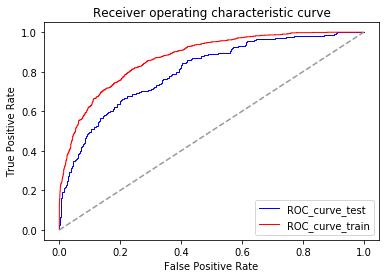

In [106]:
######ROC曲线######
import numpy as np
from scipy import interp
import matplotlib.pyplot as plt
 
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.cross_validation import StratifiedKFold

mean_tpr = 0.0
mean_fpr = np.linspace(0, 1, 100)
all_tpr = []

probas_test =  best_xgb_model.fit(x_train, y_train).predict_proba(x_test)
probas_train =  best_xgb_model.fit(x_train, y_train).predict_proba(x_train)

fpr_test, tpr_test, thresholds_test = roc_curve(y_test, probas_test[:, 1])

fpr_train, tpr_train, thresholds_raint = roc_curve(y_train, probas_train[:, 1])

#mean_tpr += interp(mean_fpr, fpr, tpr)
#mean_tpr[0] = 0.0 
roc_auc_test = auc(fpr_test, tpr_test)
roc_auc_train = auc(fpr_train, tpr_train)
print(roc_auc_test)
print(roc_auc_train)
    
#plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
plt.plot(fpr_test, tpr_test, lw=1, label='ROC_curve_test',color='blue') 
plt.plot(fpr_train, tpr_train, lw=1, label='ROC_curve_train',color='red')
plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6))
 
#mean_tpr /= len(cv) 
#mean_tpr[-1] = 1.0 
#mean_auc = auc(mean_fpr, mean_tpr)

#plt.plot(mean_fpr, mean_tpr, 'k--',
         #label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
plt.xlim([-0.05, 1.05])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve')
plt.legend(loc="lower right")
plt.show()

In [107]:
def plot_ks(y_test, y_score, positive_flag):
    # 对y_test,y_score重新设置索引
    y_test.index = np.arange(len(y_test))
    y_score.index = np.arange(len(y_score))
    # 构建目标数据集
    target_data = pd.DataFrame({'y_test':list(y_test.iloc[:,0]), 'y_score':list(y_score.iloc[:,0])})
    # 按y_score降序排列
    target_data.sort_values(by = 'y_score', ascending = False, inplace = True)
    # 自定义分位点
    cuts = np.arange(0.1,1,0.1)
    # 计算各分位点对应的Score值
    index = len(target_data.y_score)*cuts
    scores = target_data.y_score.iloc[index.astype('int')]
    # 根据不同的Score值，计算Sensitivity和Specificity
    Sensitivity = []
    Specificity = []
    difference=[]
    for score in scores:
        # 正例覆盖样本数量与实际正例样本量
        positive_recall = target_data.loc[(target_data.y_test == positive_flag) & (target_data.y_score>score),:].shape[0]
        positive = sum(target_data.y_test == positive_flag)
        # 负例覆盖样本数量与实际负例样本量
        negative_recall = target_data.loc[(target_data.y_test != positive_flag) & (target_data.y_score<=score),:].shape[0]
        negative = sum(target_data.y_test != positive_flag)
        Sensitivity.append(positive_recall/positive)
        Specificity.append(negative_recall/negative)
        difference.append((positive_recall/positive)-(negative_recall/negative))
    # 构建绘图数据
    plot_data = pd.DataFrame({'cuts':cuts,'y1':1-np.array(Specificity),'y2':np.array(Sensitivity),
                               'ks':np.array(Sensitivity)-(1-np.array(Specificity)),
                               'difference':np.array(difference)})
    # 寻找Sensitivity和1-Specificity之差的最大值索引
    max_ks_index = np.argmax(plot_data.ks)
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y1.tolist()+[1], label = '1-Specificity')
    plt.plot([0]+cuts.tolist()+[1], [0]+plot_data.y2.tolist()+[1], label = 'Sensitivity')
    plt.plot([0]+cuts.tolist(), [0]+plot_data.ks.tolist(), label = 'ks')
    # 添加参考线
    plt.vlines(plot_data.cuts[max_ks_index], ymin = plot_data.y1[max_ks_index],
               ymax = plot_data.y2[max_ks_index], linestyles = '--')
    # 添加文本信息
    plt.text(x = plot_data.cuts[max_ks_index]+0.01,
             y = plot_data.y1[max_ks_index]+plot_data.ks[max_ks_index]/2,
             s = 'KS= %.2f' %plot_data.ks[max_ks_index])
    # 显示图例
    plt.legend()
    
    # 显示图形
    
    plt.show()

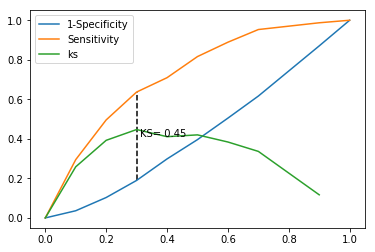

In [108]:
plot_ks(y_test=y_test, y_score=y_score, positive_flag=1)

# 使用kfold进行5折交叉验证

In [109]:
from sklearn.model_selection import train_test_split,cross_val_score,cross_validate

In [110]:
from sklearn.cross_validation import KFold

In [111]:
kf=KFold(data_x_by_iv.shape[0],n_folds=5,shuffle=True,random_state=2018)

In [112]:
df_result_kflod=pd.DataFrame(columns=['accuracy','precision','recall','f1_score','roc_auc_score'])

In [113]:
row=0
for i,(train, test) in enumerate(kf):
    x_train=data_x_std_byiv.loc[train]
    y_train=data_y.loc[train]
    x_test=data_x_std_byiv.loc[test]
    y_test=data_y.loc[test]
    best_xgb_model.fit(x_train,y_train)
    y_pred=best_xgb_model.predict(x_test)
    y_pred_proba=best_xgb_model.predict_proba(x_test)[:,1]
    acc,p,r,f1=evaluate(y_pred,y_test)
    auc=roc_auc_score(y_test,y_pred_proba)
    df_result_kflod.loc[row]=[acc,p,r,f1,auc]
    row+=1
df_result_kflod

,accuracy,precision,recall,f1_score,roc_auc_score
0,0.60,0.5,1.0,0.666667,0.666667
1,0.40,0.0,0.0,0.000000,1.000000
2,0.75,0.5,1.0,0.666667,0.666667
3,0.25,0.0,0.0,0.000000,0.500000
4,0.50,0.5,1.0,0.666667,0.125000


In [114]:
df_result_kflod.mean()

accuracy         0.500000
precision        0.300000
recall           0.600000
f1_score         0.400000
roc_auc_score    0.591667
dtype: float64

# 使用cross_val_score进行5折交叉验证

In [115]:
def muti_score(model):
    accuracy = cross_val_score(model, data_x_std_byiv, data_y, scoring='accuracy', cv=5)
    precision = cross_val_score(model, data_x_std_byiv, data_y, scoring='precision', cv=5)
    recall = cross_val_score(model, data_x_std_byiv, data_y, scoring='recall', cv=5)
    f1_score = cross_val_score(model, data_x_std_byiv, data_y, scoring='f1', cv=5)
    auc = cross_val_score(model, data_x_std_byiv, data_y, scoring='roc_auc', cv=5)
    return list((sum(accuracy)/5,sum(precision)/5,sum(recall)/5,sum(f1_score)/5,sum(auc)/5))

In [116]:
parms_df=pd.DataFrame({'LR':best_model['lr_model'],'svm':best_model['svm_model'],
                       'knn':best_model['knn_model'],'decision tree':best_model['dt_model'],
                       'xgboost':best_model['xgb_model'],'random forest':best_model['rf_model']})

In [118]:
best_model

{'lr_model': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
           penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
           verbose=0, warm_start=False),
 'svm_model': SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
   decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
   max_iter=-1, probability=True, random_state=None, shrinking=True,
   tol=0.001, verbose=False),
 'knn_model': KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
            metric_params=None, n_jobs=1, n_neighbors=10, p=1,
            weights='distance'),
 'dt_model': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fract

In [119]:
muti_score(best_model['xgb_model'])

[0.8010082722114248,
 0.6847218811463626,
 0.38476495200590694,
 0.49244476024118056,
 0.7925241367934255]

In [120]:
score_df=pd.DataFrame(columns=['accuracy','precision','recall','f1_score','roc_auc_score'])

In [121]:
score_df

,accuracy,precision,recall,f1_score,roc_auc_score


In [122]:
for name,model in best_model.items():
    score_df.loc[name]=muti_score(model)

In [123]:
score_df

,accuracy,precision,recall,f1_score,roc_auc_score
lr_model,0.795121,0.697040,0.325252,0.443244,0.787575
svm_model,0.793650,0.736259,0.279150,0.403906,0.749959
knn_model,0.780397,0.638695,0.285883,0.394215,0.726312
dt_model,0.701926,0.405989,0.417411,0.429001,0.611642
xgb_model,0.801008,0.684722,0.384765,0.492445,0.792524
rf_model,0.779975,0.765819,0.179399,0.289684,0.779879


可以看出，xgboost是最好的模型

# 模型融合

In [124]:
from mlxtend.classifier import StackingClassifier

In [153]:
best_model['xgb_model']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eta=0.1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)

In [144]:
sclf = StackingClassifier(classifiers=[best_model['lr_model'], best_model['svm_model'],
                                       best_model['knn_model'], best_model['dt_model'],
                                       best_model['xgb_model'],best_model['rf_model']],
                          meta_classifier=best_model['xgb_model'])

In [145]:
sclf.fit(x_train, y_train)

y_predict_stacking = sclf.predict(x_test)

In [146]:
y_predict_stacking

array([0, 1, 1, 1], dtype=int64)

In [147]:
fpr_stacking, tpr_stacking, thresholds_stacking  = roc_curve(y_test, y_predict_stacking)

In [149]:
display(accuracy_score(y_predict_stacking, y_test))
#print(classification_report(y_predict_stacking, y_test))

0.25

In [151]:
accuracy_score(y_predict_stacking, y_test)

0.25

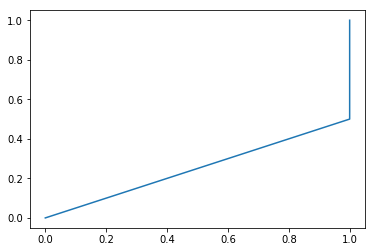

In [150]:
plt.plot(fpr_stacking, tpr_stacking, label='Stacking ROC')